In [ ]:
# 针对问题二，基于yolov5模型，利用附件2中的数据对模型进行微调，使其具备单字检测分割的能力。
# 我们将部分分割结果可视化，验证模型分割能力。

In [ ]:
# 因为我们使用的是yolov5模型，模型比较大，所以完整代码不在此处（jupyter文件）贴出，但我们会提供yolo代码的py文件
# 一下训练代码是train.py文件的一部分
# 我们使用yolov5x model 是一个参数量较大的模型，因为本次赛题是数据集也比较大，尤其是第四问，附件中包含四万多张图片

In [ ]:
# yolov5 训练代码
def main(opt, callbacks=Callbacks()):
    """Runs training or hyperparameter evolution with specified options and optional callbacks."""
    if RANK in {-1, 0}:
        print_args(vars(opt))
        check_git_status()
        check_requirements(ROOT / "requirements.txt")

    # Resume (from specified or most recent last.pt)
    if opt.resume and not check_comet_resume(opt) and not opt.evolve:
        last = Path(check_file(opt.resume) if isinstance(opt.resume, str) else get_latest_run())
        opt_yaml = last.parent.parent / "opt.yaml"  # train options yaml
        opt_data = opt.data  # original dataset
        if opt_yaml.is_file():
            with open(opt_yaml, errors="ignore") as f:
                d = yaml.safe_load(f)
        else:
            d = torch.load(last, map_location="cpu")["opt"]
        opt = argparse.Namespace(**d)  # replace
        opt.cfg, opt.weights, opt.resume = "", str(last), True  # reinstate
        if is_url(opt_data):
            opt.data = check_file(opt_data)  # avoid HUB resume auth timeout
    else:
        opt.data, opt.cfg, opt.hyp, opt.weights, opt.project = (
            check_file(opt.data),
            check_yaml(opt.cfg),
            check_yaml(opt.hyp),
            str(opt.weights),
            str(opt.project),
        )  # checks
        assert len(opt.cfg) or len(opt.weights), "either --cfg or --weights must be specified"
        if opt.evolve:
            if opt.project == str(ROOT / "runs/train"):  # if default project name, rename to runs/evolve
                opt.project = str(ROOT / "runs/evolve")
            opt.exist_ok, opt.resume = opt.resume, False  # pass resume to exist_ok and disable resume
        if opt.name == "cfg":
            opt.name = Path(opt.cfg).stem  # use model.yaml as name
        opt.save_dir = str(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))

    # DDP mode
    device = select_device(opt.device, batch_size=opt.batch_size)
    if LOCAL_RANK != -1:
        msg = "is not compatible with YOLOv5 Multi-GPU DDP training"
        assert not opt.image_weights, f"--image-weights {msg}"
        assert not opt.evolve, f"--evolve {msg}"
        assert opt.batch_size != -1, f"AutoBatch with --batch-size -1 {msg}, please pass a valid --batch-size"
        assert opt.batch_size % WORLD_SIZE == 0, f"--batch-size {opt.batch_size} must be multiple of WORLD_SIZE"
        assert torch.cuda.device_count() > LOCAL_RANK, "insufficient CUDA devices for DDP command"
        torch.cuda.set_device(LOCAL_RANK)
        device = torch.device("cuda", LOCAL_RANK)
        dist.init_process_group(
            backend="nccl" if dist.is_nccl_available() else "gloo", timeout=timedelta(seconds=10800)
        )

    # Train
    #.......
# Select the fittest individuals for reproduction using adaptive tournament selection
            selected_indices = []
            for _ in range(pop_size - elite_size):
                # Adaptive tournament size
                tournament_size = max(
                    max(2, tournament_size_min),
                    int(min(tournament_size_max, pop_size) - (generation / (opt.evolve / 10))),
                )
                # Perform tournament selection to choose the best individual
                tournament_indices = random.sample(range(pop_size), tournament_size)
                tournament_fitness = [fitness_scores[j] for j in tournament_indices]
                winner_index = tournament_indices[tournament_fitness.index(max(tournament_fitness))]
                selected_indices.append(winner_index)

            # Add the elite individuals to the selected indices
            elite_indices = [i for i in range(pop_size) if fitness_scores[i] in sorted(fitness_scores)[-elite_size:]]
            selected_indices.extend(elite_indices)
            # Create the next generation through crossover and mutation
            next_generation = []
            for _ in range(pop_size):
                parent1_index = selected_indices[random.randint(0, pop_size - 1)]
                parent2_index = selected_indices[random.randint(0, pop_size - 1)]
                # Adaptive crossover rate
                crossover_rate = max(
                    crossover_rate_min, min(crossover_rate_max, crossover_rate_max - (generation / opt.evolve))
                )
                if random.uniform(0, 1) < crossover_rate:
                    crossover_point = random.randint(1, len(hyp_GA) - 1)
                    child = population[parent1_index][:crossover_point] + population[parent2_index][crossover_point:]
                else:
                    child = population[parent1_index]
                # Adaptive mutation rate
                mutation_rate = max(
                    mutation_rate_min, min(mutation_rate_max, mutation_rate_max - (generation / opt.evolve))
                )
                for j in range(len(hyp_GA)):
                    if random.uniform(0, 1) < mutation_rate:
                        child[j] += random.uniform(-0.1, 0.1)
                        child[j] = min(max(child[j], gene_ranges[j][0]), gene_ranges[j][1])
                next_generation.append(child)
            # Replace the old population with the new generation
            population = next_generation
        # Print the best solution found
        best_index = fitness_scores.index(max(fitness_scores))
        best_individual = population[best_index]
        print("Best solution found:", best_individual)
        # Plot results
        plot_evolve(evolve_csv)
        LOGGER.info(
            f'Hyperparameter evolution finished {opt.evolve} generations\n'
            f"Results saved to {colorstr('bold', save_dir)}\n"
            f'Usage example: $ python train.py --hyp {evolve_yaml}'
        )

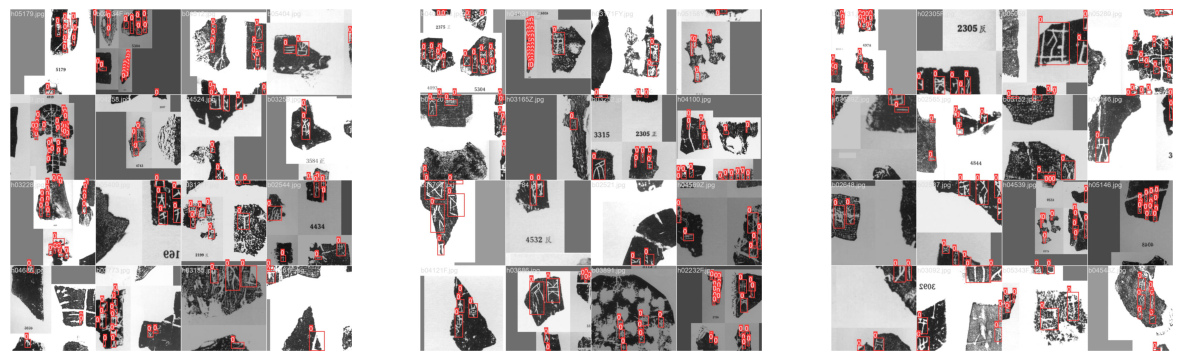

In [1]:
# 训练结果可视化，我们微调的模型在训练集上识别准确率如下图所示：（我们提供了三张训练集上的识别准确率图像）
import matplotlib.pyplot as plt
import cv2

# 读取图像
image_path1 = "jupyter_need/test_datasets0.jpg"
image_path2 = "jupyter_need/test_datasets1.jpg"
image_path3 = "jupyter_need/test_datasets2.jpg"

image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
image3 = cv2.imread(image_path3)

# 创建一个具有三个子图的图形
plt.figure(figsize=(15, 5))

# 在第一个子图中显示第一张图片
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis('off')

# 在第二个子图中显示第二张图片
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.axis('off')

# 在第三个子图中显示第三张图片
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
plt.axis('off')

# 展示图片
plt.show()


In [ ]:
# 为了评估我们模型的性能，我们计算了在训练集上50个epoch的F1_CURVE、P_CURVE、R_CURVE和PR_CURVE
# F1 曲线是用于评估二元分类器性能的一种图形化指标。它显示了在不同阈值下的 F1 分数随着真阳性率（召回率）的变化情况。
# F1 分数是精确度（Precision）和召回率（Recall）的调和平均值,它可以帮助我们在精确度和召回率之间找到一个平衡点。
# "P curve" 通常指代 "Precision-Recall curve"，即精确度-召回率曲线。它是用于评估分类模型性能的一种常见工具，特别是在处理不平衡数据集时。
# Precision-Recall 曲线显示了在不同阈值下的精确度和召回率之间的关系。精确度（Precision）是被正确分类的正例占所有被分类为正例的样本的比例，
# 召回率（Recall）是被正确分类的正例占所有实际正例的样本的比例。
# 绘制 P-R 曲线的过程类似于绘制 ROC 曲线，只是在 P-R 曲线中，横轴通常是召回率，纵轴是精确度。在绘制过程中，
# 可以通过在模型输出的概率或得分上变化阈值，计算不同阈值下的精确度和召回率，并绘制曲线。
# P-R 曲线对于不平衡数据集的分类器评估尤为重要，因为它可以更清晰地显示出分类器在不同类别之间的性能差异。
# 通常情况下，当类别不平衡时，使用 P-R 曲线比 ROC 曲线更能展现出分类器的优势和缺陷。

# 以下是这些指标的具体结果图：

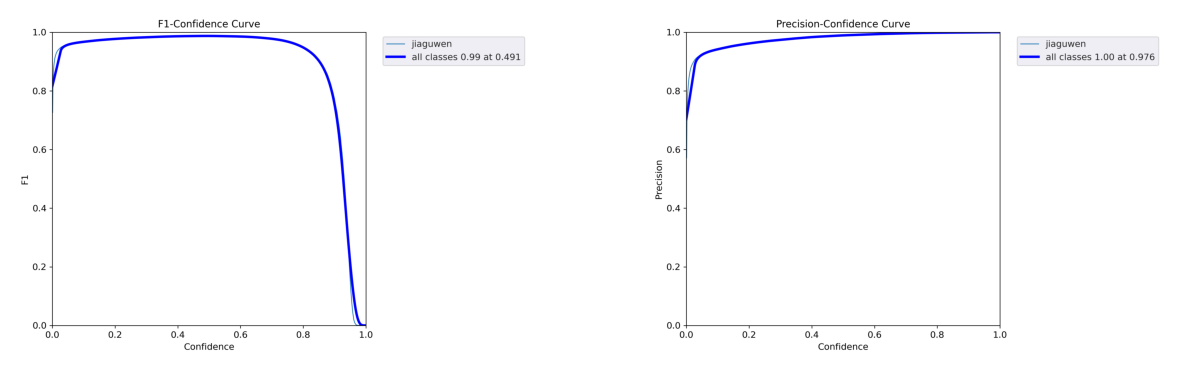

In [3]:
import matplotlib.pyplot as plt
import cv2

# 读取图像
image_path1 = "jupyter_need/F1_curve.png"
image_path2 = "jupyter_need/P_curve.png"
image_path3 = "jupyter_need/PR_curve.png"

image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
image3 = cv2.imread(image_path3)

# 创建一个具有三个子图的图形
plt.figure(figsize=(15, 5))

# 在第一个子图中显示第一张图片
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis('off')

# 在第二个子图中显示第二张图片
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.axis('off')

# 展示图片
plt.show()

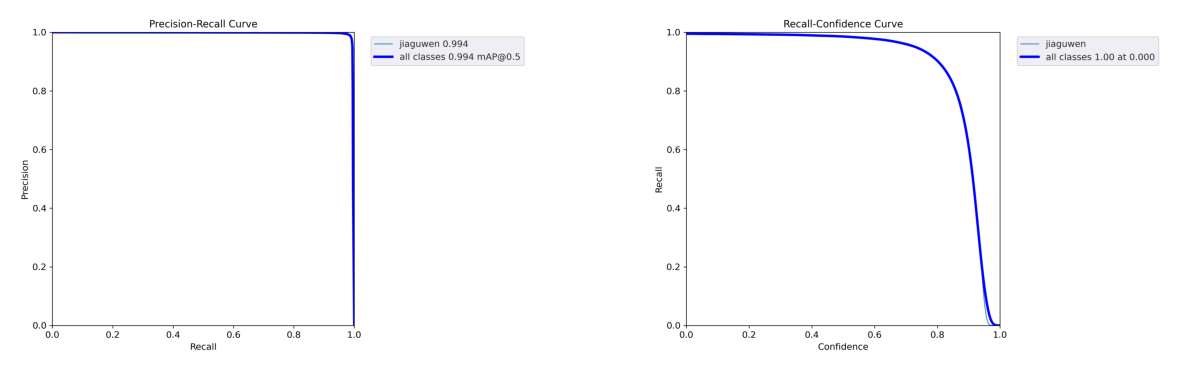

In [4]:
import matplotlib.pyplot as plt
import cv2

# 读取图像
image_path1 = "jupyter_need/PR_curve.png"
image_path2 = "jupyter_need/R_curve.png"
image_path3 = "jupyter_need/PR_curve.png"

image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
image3 = cv2.imread(image_path3)

# 创建一个具有三个子图的图形
plt.figure(figsize=(15, 5))

# 在第一个子图中显示第一张图片
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis('off')

# 在第二个子图中显示第二张图片
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.axis('off')

# 展示图片
plt.show()

In [ ]:
# 为了进一步验证模型的有效性，我们计算了模型结果的混淆矩阵
# 混淆矩阵（Confusion Matrix）是用于评估分类模型性能的一种表格形式的工具。它对于了解分类器在不同类别上的预测情况非常有用。
# 结果如下：

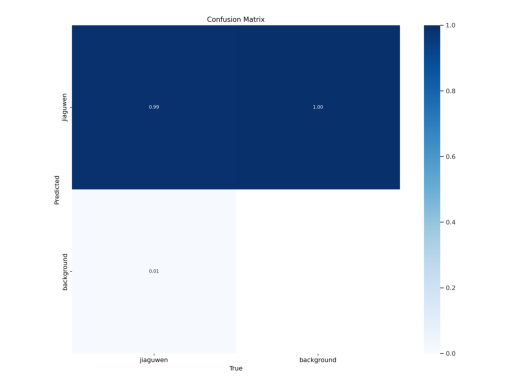

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 读取图像文件
image = mpimg.imread('jupyter_need/confusion_matrix.png')
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# 训练loss记录如下：

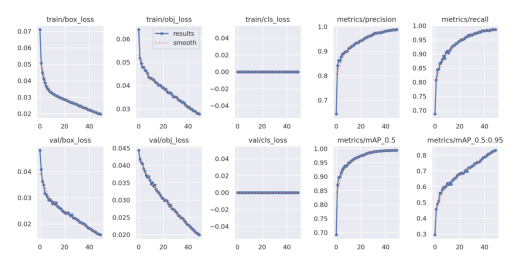

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 读取图像文件
image = mpimg.imread('jupyter_need/results.png')
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# 利用第二问（前面）微调好的yolo，我们在对附件三中的200张甲骨文原始图像进行自动单字分割，分割结果保存在Test_results.xlsx文件中
#自动分割代码如下：

In [ ]:
# 完整inference代码在segment/val.py中
def main(opt):
    """Executes YOLOv5 tasks including training, validation, testing, speed, and study with configurable options."""
    check_requirements(ROOT / "requirements.txt", exclude=("tensorboard", "thop"))

    if opt.task in ("train", "val", "test"):  # run normally
        if opt.conf_thres > 0.001:  # https://github.com/ultralytics/yolov5/issues/1466
            LOGGER.warning(f"WARNING ⚠️ confidence threshold {opt.conf_thres} > 0.001 produces invalid results")
        if opt.save_hybrid:
            LOGGER.warning("WARNING ⚠️ --save-hybrid returns high mAP from hybrid labels, not from predictions alone")
        run(**vars(opt))

    else:
        weights = opt.weights if isinstance(opt.weights, list) else [opt.weights]
        opt.half = torch.cuda.is_available() and opt.device != "cpu"  # FP16 for fastest results
        if opt.task == "speed":  # speed benchmarks
            # python val.py --task speed --data coco.yaml --batch 1 --weights yolov5n.pt yolov5s.pt...
            opt.conf_thres, opt.iou_thres, opt.save_json = 0.25, 0.45, False
            for opt.weights in weights:
                run(**vars(opt), plots=False)

        elif opt.task == "study":  # speed vs mAP benchmarks
            # python val.py --task study --data coco.yaml --iou 0.7 --weights yolov5n.pt yolov5s.pt...
            for opt.weights in weights:
                f = f"study_{Path(opt.data).stem}_{Path(opt.weights).stem}.txt"  # filename to save to
                x, y = list(range(256, 1536 + 128, 128)), []  # x axis (image sizes), y axis
                for opt.imgsz in x:  # img-size
                    LOGGER.info(f"\nRunning {f} --imgsz {opt.imgsz}...")
                    r, _, t = run(**vars(opt), plots=False)
                    y.append(r + t)  # results and times
                np.savetxt(f, y, fmt="%10.4g")  # save
            subprocess.run(["zip", "-r", "study.zip", "study_*.txt"])
            plot_val_study(x=x)  # plot
        else:
            raise NotImplementedError(f'--task {opt.task} not in ("train", "val", "test", "speed", "study")')